In [3]:
%config Completer.use_jedi = False

import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

import os

In [26]:
dnames = os.listdir('../data/all_new_data/demultiplexed_data/220208_upload_bulk/bam.5MM_1MM/')
dnames = [x for x in dnames if 'star' in x]
dnames

['21s004252_DMSO_DMSO.star',
 '21s004254_YM155_DMSO.star',
 '21s004254_DMSO_DMSO.star',
 '21s004252_YM155_Trametinib.star',
 '21s004253_DMSO_DMSO.star',
 '21s004256_Trametinib_DMSO.star',
 '21s004253_YM155_DMSO.star',
 '21s004253_Trametinib_DMSO.star',
 '21s004251_DMSO_DMSO.star',
 '21s004252_YM155_DMSO.star',
 '21s004256_DMSO_DMSO.star',
 '21s004253_Trametinib_YM155.star',
 '21s004254_medium_medium.star',
 '21s004252_Trametinib_DMSO.star',
 '21s004258_DMSO_DMSO.star',
 '21s004251_Trametinib_YM155.star',
 '21s004258_Trametinib_DMSO.star',
 '21s004258_medium_medium.star',
 '21s004251_Trametinib_DMSO.star',
 '21s004254_Trametinib_DMSO.star',
 '21s004251_YM155_Trametinib.star',
 '21s004256_Trametinib_YM155.star',
 '21s004256_medium_medium.star',
 '21s004253_YM155_Trametinib.star',
 '21s004254_Trametinib_YM155.star',
 '21s004258_YM155_DMSO.star',
 '21s004256_YM155_DMSO.star',
 '21s004252_Trametinib_YM155.star',
 '21s004258_Trametinib_YM155.star',
 '21s004251_YM155_DMSO.star']

In [27]:
meta = pd.read_csv('../data/all_new_data/20211217_bulk_NHD_file_sample_barcode_list.csv',
                  sep=',', header=0, index_col=None)

In [47]:
temp = pd.read_csv('../data/all_new_data/demultiplexed_data/220208_upload_bulk/bam.5MM_1MM/21s004251_DMSO_DMSO.star/21s004251_DMSO_DMSOReadsPerGene.out.tab',
                  sep='\t', header=None, index_col=0, skiprows=4)

In [60]:
results = pd.DataFrame(index=temp.index, columns=meta.index)

In [77]:
fnames = []
for i in meta.index:
    sample, drug, barcode = meta.loc[i]
    fname = sample.split('_')[2] + '_' + drug
    data = pd.read_csv('../data/all_new_data/demultiplexed_data/220208_upload_bulk/bam.5MM_1MM/%s.star/%sReadsPerGene.out.tab' % (fname, fname),
                  sep='\t', header=None, index_col=0, skiprows=4)
    results[i] = data[1]
    fnames.append(fname)

In [78]:
results.columns = fnames
meta['name'] = fnames


In [87]:
meta_combi = meta.iloc[:15]
meta_poly = meta.iloc[15:]
meta_combi.index = meta_combi['name']
meta_poly.index = meta_poly['name']

In [236]:
results_combi = results[meta_combi.index]
results_poly = results[meta_poly.index]

In [238]:
results_combi = results_combi[(results_combi!=0).sum(1) > 0]
results_poly = results_poly[(results_poly!=0).sum(1) > 0]

In [239]:
meta_combi.to_csv('../results/bulk/meta_combi.csv')
meta_poly.to_csv('../results/bulk/meta_poly.csv')
results_combi.to_csv('../results/bulk/count_combi.csv')
results_poly.to_csv('../results/bulk/count_ploy.csv')

In [240]:
from sklearn.decomposition import PCA

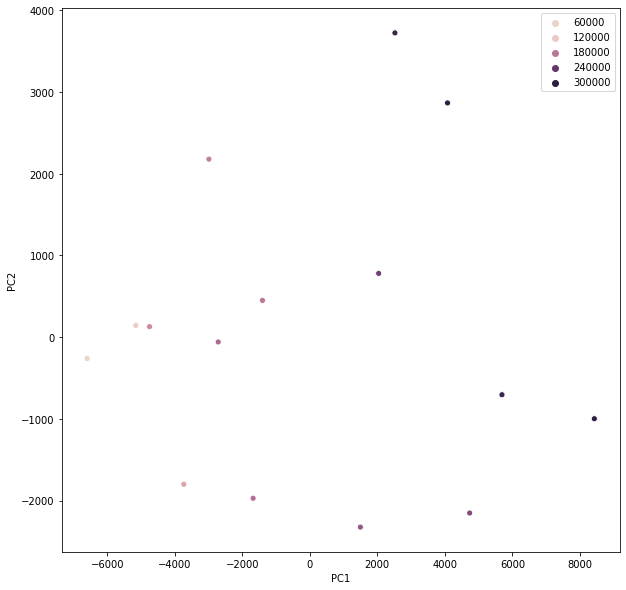

In [251]:
model = PCA(2)
poly_pca = model.fit_transform(results_poly.T)
poly_pca = pd.DataFrame(poly_pca, index=meta_poly.index, columns=['PC1', 'PC2'])
plt.figure(figsize=(10, 10))
sns.scatterplot(x=poly_pca['PC1'], y=poly_pca['PC2'], hue=results_poly.sum())

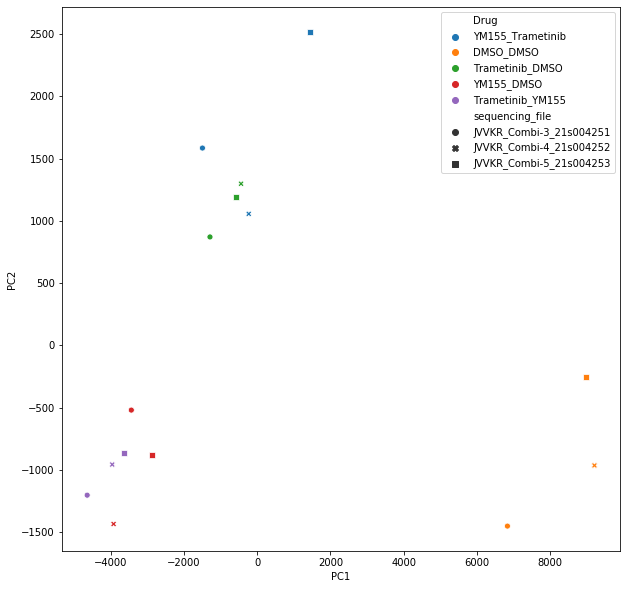

In [242]:
model = PCA(2)
combi_pca = model.fit_transform(results_combi.T)
combi_pca = pd.DataFrame(combi_pca, index=meta_combi.index, columns=['PC1', 'PC2'])
plt.figure(figsize=(10, 10))
sns.scatterplot(x=combi_pca['PC1'], y=combi_pca['PC2'], hue=meta_combi['Drug'], style=meta_combi['sequencing_file'])

In [244]:
temp = pd.read_csv('../results/bulk/DE-analysis/combi/Trametinib_DMSO.csv',
                  sep=',', header=0, index_col=0)
data_combi = pd.DataFrame(index=temp.index)
fnames = os.listdir('../results/bulk/DE-analysis/combi/')
for fname in fnames:
    temp = pd.read_csv('../results/bulk/DE-analysis/combi/' + fname,
                  sep=',', header=0, index_col=0)
    data_combi[fname] = temp['log2FoldChange']

In [245]:
temp = pd.read_csv('../results/bulk/DE-analysis/poly/Trametinib_DMSO.csv',
                  sep=',', header=0, index_col=0)
data_poly = pd.DataFrame(index=temp.index)
fnames = os.listdir('../results/bulk/DE-analysis/poly/')
for fname in fnames:
    temp = pd.read_csv('../results/bulk/DE-analysis/poly/' + fname,
                  sep=',', header=0, index_col=0)
    data_poly[fname] = temp['log2FoldChange']

In [246]:
data_poly.columns = [x + '_poly' for x in data_poly.columns]
data_combi.columns = [x + '_combi' for x in data_combi.columns]

In [250]:
data_poly.abs().sum()

Trametinib_DMSO.csv_poly     29105.084176
medium_medium.csv_poly       28599.673764
Trametinib_YM155.csv_poly    29508.497633
YM155_DMSO.csv_poly          29056.900832
dtype: float64

In [231]:
genes = list(set(data_combi.index) | set(data_poly.index))

In [232]:
data = pd.concat([data_combi.loc[genes], data_poly.loc[genes]], 1)

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

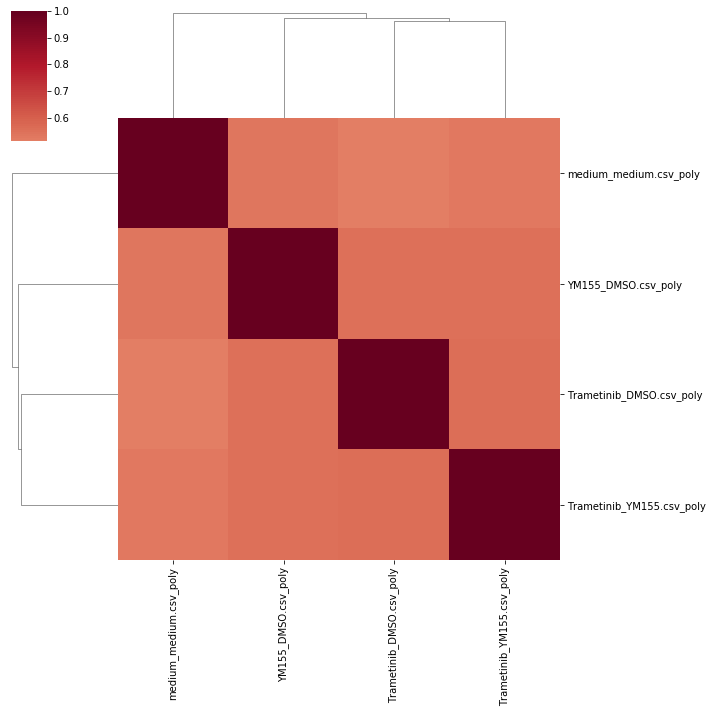

In [235]:
sns.clustermap(data_poly.corr(), center=0, cmap='RdBu_r')

In [260]:
temp = pd.read_csv('../results/bulk/vst_combi.csv', 
                  sep=',', header=0, index_col=0)
model = PCA(2)
temp_pca = model.fit_transform(temp.T)
temp_pca = pd.DataFrame(temp_pca,index=temp.columns, columns=['PC1', 'PC2'])
temp

,21s004251_YM155_Trametinib,21s004252_YM155_Trametinib,21s004253_YM155_Trametinib,21s004251_DMSO_DMSO,21s004252_DMSO_DMSO,21s004253_DMSO_DMSO,21s004251_Trametinib_DMSO,21s004252_Trametinib_DMSO,21s004253_Trametinib_DMSO,21s004251_YM155_DMSO,21s004252_YM155_DMSO,21s004253_YM155_DMSO,21s004251_Trametinib_YM155,21s004252_Trametinib_YM155,21s004253_Trametinib_YM155
ENSG00000225972,10.080586,9.996316,10.108253,10.004184,10.047495,9.953862,10.039429,10.076219,10.110061,10.069738,10.018392,10.006558,10.058214,9.953862,9.953862
ENSG00000225630,9.996115,9.953862,9.953862,9.953862,9.992093,9.980619,9.953862,9.953862,10.021525,9.953862,9.953862,9.953862,9.953862,9.953862,9.953862
ENSG00000237973,10.224031,9.953862,10.013682,10.011967,10.020076,9.980619,10.027968,10.126850,9.953862,10.170500,10.177198,10.006558,10.162430,10.136129,10.011553
ENSG00000229344,9.953862,9.953862,10.013682,10.083755,10.080623,10.042594,9.996650,9.997133,10.009110,10.011812,10.065613,10.045125,9.953862,10.014654,9.953862
ENSG00000240409,9.953862,10.088069,9.988401,9.953862,9.953862,9.953862,9.953862,9.953862,9.953862,9.953862,9.953862,9.953862,9.953862,9.953862,9.953862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000198695,10.700209,10.270931,10.488111,10.077093,10.234367,10.162665,10.719795,10.277010,10.347219,10.286045,10.425992,10.389954,9.953862,10.089756,10.406293
ENSG00000210194,10.038360,9.953862,9.953862,10.004184,9.953862,9.953862,9.953862,10.059834,9.953862,9.953862,9.953862,10.082906,9.953862,10.039828,10.184395
ENSG00000198727,11.185845,11.681289,11.059087,10.758977,10.713970,10.755129,11.304362,11.354739,11.571631,10.711768,11.038456,10.857846,11.218692,10.829720,11.230015
ENSG00000210195,9.953862,9.953862,9.953862,9.953862,9.953862,9.953862,10.049526,9.953862,9.992930,9.953862,9.953862,9.953862,10.239239,9.953862,9.953862


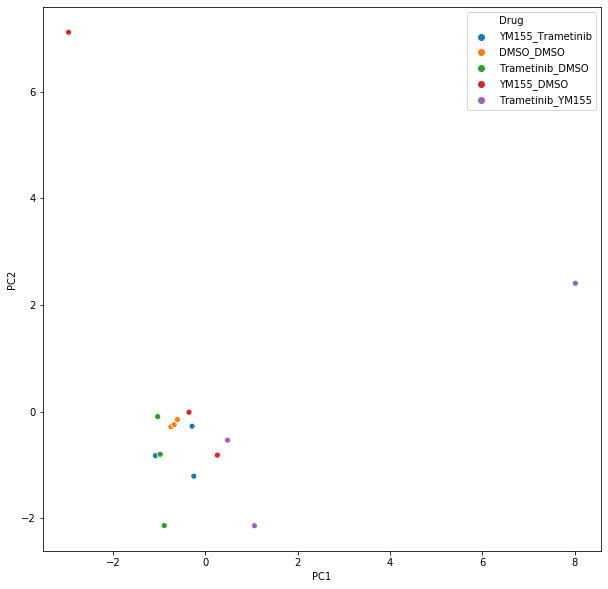

In [261]:
plt.figure(figsize=(10,10))
sns.scatterplot(temp_pca['PC1'], temp_pca['PC2'], hue=meta_combi['Drug'])

In [169]:
fil = data_poly.abs()>0.05
data_poly[fil] = 0
data_poly[~fil] = 1 * np.sign(data_poly)

In [175]:
data_combi['YM155_DMSO.csv_combi'].sort_values()

ENSG00000181163   -1.0
ENSG00000134825   -1.0
ENSG00000137522   -1.0
ENSG00000283023   -1.0
ENSG00000100181   -1.0
                  ... 
ENSG00000184983    1.0
ENSG00000103257    1.0
ENSG00000159217    1.0
ENSG00000172922    1.0
ENSG00000114861    1.0
Name: YM155_DMSO.csv_combi, Length: 6552, dtype: float64